In [1]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.linear_model import LinearRegression
from sklearn import linear_model

In [2]:
from MuDataFrame import *
import numpy as np
from scipy import stats

mdfo_calib = MuDataFrame("/Volumes/DAQ/PhotonTimeProp/dataFiles/calibration_new_set_up.csv")

mdf_calib = mdfo_calib.events_df

mdfo_calib.og_df = mdf_calib.copy()
mdfo_calib.show()

,Unnamed: 0,index,event_num,event_time,deadtime,l1hit,l2hit,l3hit,l4hit,r1hit,...,z_angle,SmallCounter,speed,Run_Num,xx,yy,xx1,yy1,time_of_day,time
0,0,0,0,2021-05-03 12:40:15.812760,0,1.0,1.0,1.0,1.0,1.0,...,13.455446,NaN,0.342978,622,-5.445887,-22.562492,-6.807692,-22.684615,day,0
1,1,1,1,2021-05-03 12:40:16.502963,0,1.0,1.0,1.0,1.0,1.0,...,12.002813,NaN,0.703353,622,-11.762760,-21.506829,-11.538462,-21.784615,day,690203
2,2,2,2,2021-05-03 12:40:16.672924,0,1.0,1.0,1.0,1.0,1.0,...,14.672630,NaN,0.210716,622,35.347122,13.620282,36.676923,14.884615,day,860164
3,3,3,3,2021-05-03 12:40:16.892987,0,1.0,1.0,1.0,1.0,1.0,...,15.284964,NaN,0.259347,622,24.903617,25.826667,27.746154,29.153846,day,1080227
4,4,4,4,2021-05-03 12:40:17.563102,0,1.0,1.0,1.0,1.0,1.0,...,4.253100,NaN,11.038012,622,6.978340,14.482143,7.676923,15.230769,day,1750342
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2999995,2999995,99995,2999995,2021-05-20 13:18:30.375574,0,0.0,0.0,1.0,1.0,0.0,...,NaN,NaN,NaN,656,NaN,NaN,NaN,NaN,day,1077345562814
2999996,2999996,99996,2999996,2021-05-20 13:18:30.965416,0,1.0,1.0,1.0,1.0,1.0,...,6.035804,NaN,0.442759,656,12.892377,-12.244589,13.269231,-13.276923,day,1077346152656
2999997,2999997,99997,2999997,2021-05-20 13:18:31.405694,0,1.0,0.0,1.0,1.0,1.0,...,NaN,NaN,NaN,656,-25.480419,NaN,-27.830769,NaN,day,1077346592934
2999998,2999998,99998,2999998,2021-05-20 13:18:31.725719,0,1.0,1.0,0.0,0.0,1.0,...,NaN,NaN,NaN,656,NaN,NaN,NaN,NaN,day,1077346912959


# Getting peak coords

In [3]:
def getIntersections(t, curve1, curve2, doPlot=True):
    intersections = []
    xvals = []
    prev_dif = 0
    t0, prev_c1, prev_c2 = None, None, None
    for t1, c1, c2 in zip(t, curve1, curve2):
        new_dif = c2 - c1
        if np.abs(new_dif) < 1e-12:  # found an exact zero, this is very unprobable
            intersections.append((t1, c1))
        elif new_dif * prev_dif < 0:
            denom = prev_dif - new_dif
            xvals.append((-new_dif * t0 + prev_dif * t1) / denom)
            intersections.append(((-new_dif * t0 + prev_dif * t1) / denom,
                                  (c1 * prev_c2 - c2 * prev_c1) / denom))
        t0, prev_c1, prev_c2, prev_dif = t1, c1, c2, new_dif

    if doPlot:
        fig, ax = plt.subplots()
        ax.plot(t, curve1, 'b-')
        ax.plot(t, curve2, 'r-')
        ax.plot(*zip(*intersections), 'kx', ms=5)
        plt.show()
    
    diffs = np.diff(xvals)
    return xvals

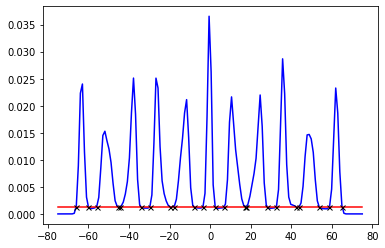

In [4]:
from scipy.stats import gaussian_kde
mdfo_calib.reload()
mdfo_calib.keep4by4Events()
data = mdfo_calib.get("diffL1")
bandwidth = 0.02
density1 = gaussian_kde(data, bw_method=bandwidth)
xs = np.linspace(-75,75,150)
t = xs
curve1 = density1(xs)
curve2 = len(curve1) * [0.00135]
vals = getIntersections(t, curve1, curve2)
L1 = np.reshape(vals,[11,2])
L1 = np.flip(L1,0)

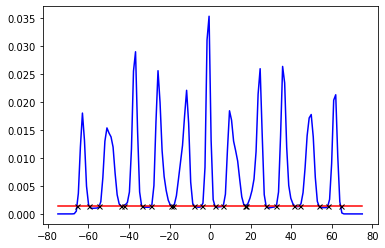

In [5]:
mdfo_calib.reload()
mdfo_calib.keep4by4Events()
data2 = mdfo_calib.get("diffL2")
bandwidth = 0.02
density2 = gaussian_kde(data2, bw_method=bandwidth)
xs = np.linspace(-75,75,150)
t = xs
curve1 = density2(xs)
curve2 = len(curve1) * [0.0015]
vals2 = getIntersections(t, curve1, curve2)
L2 = np.reshape(vals2,[11,2])
L2 = np.flip(L2,0)

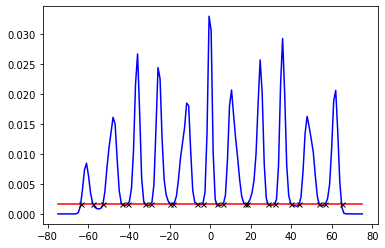

In [6]:
mdfo_calib.reload()
mdfo_calib.keep4by4Events()
data3 = mdfo_calib.get("diffL3")
bandwidth = 0.025
density3 = gaussian_kde(data3, bw_method=bandwidth)
xs = np.linspace(-75,75,150)
t = xs
curve1 = density3(xs)
curve2 = len(curve1) * [0.0017]
vals3 = getIntersections(t, curve1, curve2)
L3 = np.reshape(vals3,[11,2])
L3 = np.flip(L3,0)

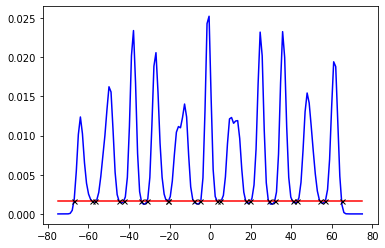

In [7]:
mdfo_calib.reload()
mdfo_calib.keep4by4Events()
data4 = mdfo_calib.get("diffL4")
bandwidth = 0.03
density4 = gaussian_kde(data4, bw_method=bandwidth)
xs = np.linspace(-75,75,150)
t = xs
curve1 = density4(xs)
curve2 = len(curve1) * [0.0016]
vals4 = getIntersections(t, curve1, curve2)
L4 = np.reshape(vals4,[11,2])

L4 = np.flip(L4,0)

# Predictions

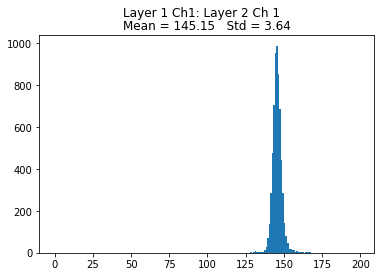

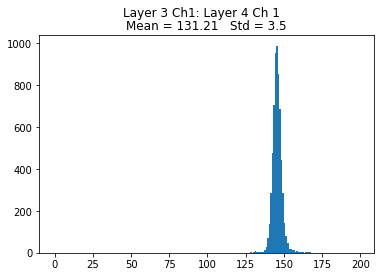

In [31]:
#pp = PdfPages('multipage.pdf')
#pp.savefig()
#pp.close()

bins = np.arange(0,200)
s = stats.describe(TDCS_L1[0])
plt.hist(TDCS_L1[0], bins=bins)
graphStats = "Mean = {}   Std = {}".format(round(s[2],2), round(np.sqrt(s[3]),2))
plt.title(graphStats)
plt.suptitle("Layer 1 Ch1: Layer 2 Ch 1")
plt.show()


t = stats.describe(TDCS_L3[0])
plt.hist(TDCS_L1[0], bins= bins)
graphStats = "Mean = {}   Std = {}".format(round(t[2],2), round(np.sqrt(t[3]),2))
plt.title(graphStats)
plt.suptitle("Layer 3 Ch1: Layer 4 Ch 1")
plt.show()

In [32]:
t[2]

131.21247089786416

In [35]:
len(L3mean)

121

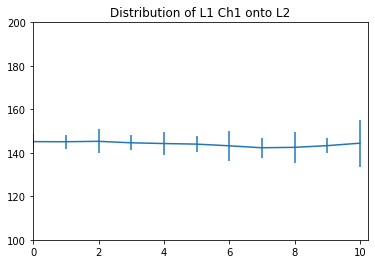

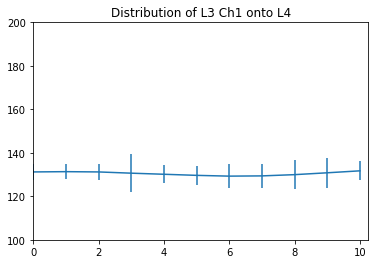

In [36]:
fig = plt.figure()
x = np.arange(11)
y = L1mean[0:11]
yerr = L1std[0:11]

axes = plt.gca()
axes.set_xlim([0,10.25])
axes.set_ylim([100,200])

plt.title("Distribution of L1 Ch1 onto L2")
plt.errorbar(x, y, xerr=0, yerr=yerr)
plt.show()


fig = plt.figure()
y3 = L3mean[0:11]
yerr3 = L3std[0:11]

axes = plt.gca()
axes.set_xlim([0,10.25])
axes.set_ylim([100,200])

plt.title("Distribution of L3 Ch1 onto L4")
plt.errorbar(x, y3, xerr=0, yerr=yerr3)
plt.show()

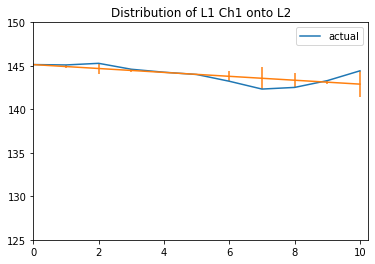

In [86]:
res = []
for i in range(11):
    res.append(abs(y[i]-y_pred[i]))

fig = plt.figure()
x = np.arange(11)
y = L1mean[0:11]
yerr = L1std[0:11]

axes = plt.gca()
axes.set_xlim([0,10.25])
axes.set_ylim([125,150])

plt.title("Distribution of L1 Ch1 onto L2")
plt.plot(x,y, label = "actual")
#plt.plot(x, y_pred3, label = "pred")
plt.errorbar(x, y_pred, xerr=0, yerr=res)
plt.legend()
plt.show()

In [141]:
"""
fig = plt.figure()
x = np.arange(11)
y = L3mean[0:11]
yerr3 = L3std[0:11]

axes = plt.gca()
axes.set_xlim([0,10.25])
axes.set_ylim([125,150])

plt.title("Distribution of L3 Ch1 onto L4")
plt.plot(x,y3, label = "actual")
#plt.plot(x, y_pred3, label = "pred")
plt.errorbar(x, y_pred3, xerr=0, yerr=res3)
plt.legend()
plt.show()
"""

'\nfig = plt.figure()\nx = np.arange(11)\ny = L3mean[0:11]\nyerr3 = L3std[0:11]\n\naxes = plt.gca()\naxes.set_xlim([0,10.25])\naxes.set_ylim([125,150])\n\nplt.title("Distribution of L3 Ch1 onto L4")\nplt.plot(x,y3, label = "actual")\n#plt.plot(x, y_pred3, label = "pred")\nplt.errorbar(x, y_pred3, xerr=0, yerr=res3)\nplt.legend()\nplt.show()\n'

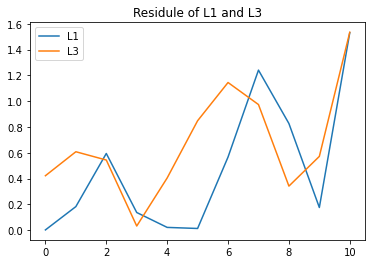

In [98]:
"""
resA1 =  [abs(ele) for ele in res]
resA3 =  [abs(ele) for ele in res3]

plt.title("Residule of L1 and L3")
plt.plot(x,resA1, label = "L1")
plt.plot(x, resA3, label = "L3")
plt.legend()
plt.show()
"""

# Predictions
### TODO: add option for function type to getYPreds

In [16]:
def getChData(data, ch, topPeaks, botPeaks):
    i = 0
    TDCS_List = []

    topDiff = "diffL" + str(ch)
    botDiff = "diffL" + str(ch+1)
    final = "L" + str(ch)
    
    for peak in topPeaks:
        # isolate the peaks
            data.reload()
            data.keep4by4Events()
            #data.keepEvents("z_angle",9.391,"<=")
            data.keepEvents(topDiff, peak[1],"<=")
            data.keepEvents(topDiff, peak[0],">=")
        # generate the L4 peaks
            #L4 = getIndividualPeaks(mdfo_calib, "diffL4",thresh=0.002,bw=0.03,doPlot=False)
            for each_peak in botPeaks:
                data.reload()
                data.keep4by4Events()
                #data.keepEvents("z_angle",9.391,"<=")
                data.keepEvents(topDiff,peak[1],"<=")
                data.keepEvents(topDiff,peak[0],">=")

                data.keepEvents(botDiff,each_peak[1],"<=")
                data.keepEvents(botDiff,each_peak[0],">=")
                # store the tdcs
                TDCS_List.append(mdfo_calib.get(final))
    return TDCS_List

In [24]:
TDCS_L1 = getChData(mdfo_calib, 1, L1, L2)
TDCS_L3 = getChData(mdfo_calib, 3, L3, L4)

142.0

In [33]:
L1mean = []
L1std = []
L3mean = []
L3std = []


for i, j in zip(TDCS_L1, TDCS_L3):
    temp1 = stats.describe(i)
    temp3 = stats.describe(j)
    L1mean.append(round(temp1[2],3))
    L1std.append(round(np.sqrt(temp1[3]),3))
    L3mean.append(round(temp3[2],3))
    L3std.append(round(np.sqrt(temp3[3]),3))

In [128]:
def getYPreds(meansList):
    ch = 0
    yPredList = []
    res = []
    for i in range(11):
        x = np.arange(11)
        x=x.reshape((11,1))
        #print (x)
        reg = linear_model.LinearRegression()
        #print(L1mean[ch:ch+11], "\n")
        reg.fit(x, meansList[ch:ch+11])
        yPredList.append(reg.predict(x))
        #print(ch,ch+11)
        for j in range(11):
            res.append(abs(meansList[j]-yPredList[i][j]))
        ch += 11
    res = np.asarray(res)
    res = res.reshape((11,11))
    return yPredList, res

In [138]:
L1_yPredList, L1_res = getYPreds(L1mean)
L3_yPredList, L3_res = getYPreds(L3mean)

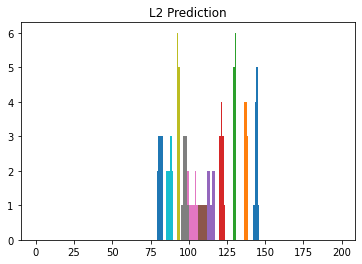

In [150]:
for i in range(11):
    plt.hist(L1_yPredList[i], bins= bins)
#graphStats = "Mean = {}   Std = {}".format(round(t[2],2), round(np.sqrt(t[3]),2))
plt.title("L2 Prediction")
#plt.suptitle("Layer 3 Ch1: Layer 4 Ch 1")
plt.show()